In [3]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statistics
import plotly.express as px
import networkx as nx
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
netflix = pd.read_csv("/content/drive/My Drive/netflix_titles.csv")

In [8]:
netflix.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [9]:
netflix.sample(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
2670,s2671,TV Show,Hasmukh,NaN,"Vir Das, Ranvir Shorey, Manoj Pahwa, Ravi Kish...",India,"April 17, 2020",2020,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Com...","A timid, small-town comedian's long-awaited bi..."
3245,s3246,TV Show,Singapore Social,NaN,"Nicole Ong, Mae Tan, Sukki Singapora, Vinny Sh...","Singapore, United States","November 22, 2019",2019,TV-MA,1 Season,"International TV Shows, Reality TV",Peer into the lives of young Singaporeans as t...
1065,s1066,TV Show,Slasher,NaN,"Katie McGrath, Brandon Jay McLaren, Steve Byer...",Canada,"April 14, 2021",2019,TV-MA,3 Seasons,"TV Horror, TV Mysteries, TV Thrillers",Rampaging serial killers leave carnage in thei...
5136,s5137,Movie,Temple,Michael Barrett,"Logan Huffman, Natalia Warner, Brandon Sklenar...","Japan, United States","December 2, 2017",2017,TV-MA,78 min,"Horror Movies, Independent Movies",Three unsuspecting American tourists visit a m...
4745,s4746,Movie,Da Kath & Kim Code,Ted Emery,"Jane Turner, Gina Riley, Glenn Robbins, Peter ...",Australia,"July 28, 2018",2005,TV-PG,82 min,Movies,Kath and Kel's union is tested by Michael Bubl...


In [10]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [11]:
netflix.shape

(8807, 12)

The dataset had 8807 samples and have 12 columns for features that can be used to derive insights from

# Data Cleaning and Preprocessing

### Handling missing values

In [12]:
netflix.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [13]:
# Replacing missing values for director and cast ad unknown
netflix['director'] = netflix['director'].fillna('Unknown')
netflix['cast'] = netflix['cast'].fillna('Unknown')

In [14]:
# Replacing null value in country with unknown
netflix['country'] = netflix['country'].fillna('Unknown')

In [15]:
# Replacing null values for ratings with most commn rating
netflix['rating'] = netflix['rating'].fillna(netflix['rating'].mode()[0])

In [16]:
#Replacing null value in duration with the average duration for each type (movei/series)

netflix[(netflix['duration'].isnull())]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...


We. can see that the data here has been mixed up ; as the ratings has the duration data and the duration data is null. It would typically require research into this data to clean it better. But I can go with two approach here.

1. Add the duration value wrongly entrerd in the `rating` column to correnponding `duration` column.

2. add mean of the druation to fill the missing value. The average duration for movies and series are generally different; movies durations are in minutes while the series data are in seasons. so we can calculate the mean for movies and series separately and fill the null value based on their corresponding type.
This would be the case if we had not found out that the duration information was wrongly placed in the rating column

We will go with option 1 for this EDA since we have the values given

### 2. Switch values for rating and duration

In [17]:
index = list(netflix[netflix.isnull()['duration'] == True].index)
netflix.loc[index, 'duration'] = netflix.loc[index, 'rating']
netflix.loc[index,'rating'] = np.nan
netflix.loc[index,:]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,NaN,74 min,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,NaN,84 min,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,NaN,66 min,Movies,The comic puts his trademark hilarious/thought...


In [18]:
netflix['duration'].isnull().sum()

0

In [17]:
netflix['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', nan, 'NR', 'TV-Y7-FV', 'UR'], dtype=object)

In [18]:
netflix[netflix['show_id'].isin(['s5542','s5795','s5814'])]  

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,NaN,74 min,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,NaN,84 min,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,NaN,66 min,Movies,The comic puts his trademark hilarious/thought...


### 2. Add average value for duration (Alternate method)

In [19]:
netflix_alt = netflix.copy() 

In [20]:
netflix_alt[netflix_alt['duration'].isnull()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description


In [21]:
netflix_alt['duration_int'] = netflix_alt['duration'].str.extract('(\d+)').fillna('0').astype(int)

In [22]:
netflix_alt.groupby('type')['duration_int'].mean()

type
Movie      99.564998
TV Show     1.764948
Name: duration_int, dtype: float64

So the average run time for a movie in netflix is approximately 100 and for series is approximately two seasons

In [23]:
netflix_alt[netflix_alt['type']=='Movie']['duration_int'].mean().round().astype(int)

100

In [24]:
netflix_alt[netflix_alt['type']=='TV Show']['duration_int'].mean().round().astype(int)

2

In [25]:
netflix_alt['duration'] = netflix_alt['duration'].fillna(str(netflix_alt[netflix_alt['type']=='Movie']['duration_int'].mean().round().astype(int)) + " " + "min")
netflix_alt['duration'] = netflix_alt['duration'].fillna(str(netflix_alt[netflix_alt['type']=='TV Show']['duration_int'].mean().round().astype(int)) + " " + "Season")

In [26]:
netflix_alt[netflix_alt['show_id'].isin(['s5542','s5795','s5814'])]  

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_int
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,NaN,74 min,Movies,"Louis C.K. muses on religion, eternal love, gi...",74
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,NaN,84 min,Movies,Emmy-winning comedy writer Louis C.K. brings h...,84
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,NaN,66 min,Movies,The comic puts his trademark hilarious/thought...,66


In [27]:
# dropping the extra duration_int column
netflix_alt.drop('duration_int', axis=1);

In [28]:
# removing the rest of the null valued data
netflix = netflix.dropna()

In [29]:
netflix.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [30]:
# Removing the duplicates
netflix.drop_duplicates(inplace=True)
netflix.shape

(8794, 12)

Separating data frame for movies and TV shows

In [31]:
netflix_movies = netflix[netflix['type']=='Movie']
netflix_series = netflix[netflix['type']=='TV Show']

In [32]:
netflix_movies.sample(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7790,s7791,Movie,Prelude to War,Frank Capra,Unknown,United States,"March 31, 2017",1942,TV-14,52 min,"Classic Movies, Documentaries",Frank Capra's documentary chronicles the rise ...
7106,s7107,Movie,"It's Okay, Buddy",Hani Hamdi,"Mahmood El-Laithi, Saad El Soghayar, Nermin Ma...",Egypt,"June 6, 2019",2017,TV-14,84 min,"Comedies, International Movies, Music & Musicals",Two down-on-their-luck singers set out to marr...
7541,s7542,Movie,My Little Pony Equestria Girls: Friendship Games,"Ishi Rudell, Jayson Thiessen","Tara Strong, Rebecca Shoichet, Ashleigh Ball, ...","United States, Canada","December 1, 2015",2015,TV-Y,72 min,"Children & Family Movies, Comedies","Rainbow Dash, Applejack and friends compete ag..."
2849,s2850,Movie,Taylor Tomlinson: Quarter-Life Crisis,Marcus Raboy,Taylor Tomlinson,United States,"March 3, 2020",2020,TV-MA,61 min,Stand-Up Comedy,She's halfway through her 20s — and she's over...
6545,s6546,Movie,Cutie and the Boxer,Zachary Heinzerling,"Noriko Shinohara, Ushio Shinohara",United States,"June 14, 2018",2013,R,82 min,Documentaries,A 2014 Oscar nominee for Best Documentary Feat...


In [33]:
netflix_series.sample(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
3127,s3128,TV Show,Cinderella and the Four Knights,Unknown,"Jung Il-woo, Ahn Jae-hyeon, Park So-dam, Lee J...",South Korea,"December 15, 2019",2016,TV-PG,1 Season,"International TV Shows, Korean TV Shows, Roman...","Catching the eye of a wealthy gentleman, spunk..."
965,s966,TV Show,Yasuke,Unknown,"LaKeith Stanfield, Takehiro Hira, Maya Tanida,...",Unknown,"April 29, 2021",2021,TV-MA,1 Season,"Anime Series, International TV Shows",A peaceful boatman once known as the Black Sam...
5435,s5436,TV Show,Man to Man,Chang-Min Lee,"Hae-Jin Park, Sung-woong Park, Min-jung Kim, J...",South Korea,"June 10, 2017",2017,TV-14,1 Season,"Crime TV Shows, International TV Shows, Korean...","Disguised as a bodyguard, a special agent must..."
1640,s1641,TV Show,Over Christmas,Unknown,"Luke Mockridge, Seyneb Saleh, Cristina do Rego...",Germany,"November 27, 2020",2020,TV-MA,1 Season,"International TV Shows, Romantic TV Shows, TV ...",Down-and-out musician Bastian battles the blue...
2983,s2984,TV Show,Night on Earth,Unknown,Samira Wiley,United Kingdom,"January 29, 2020",2020,TV-PG,1 Season,"Docuseries, Science & Nature TV",This nature series’ new technology lifts night...


##Netflix Recommendation

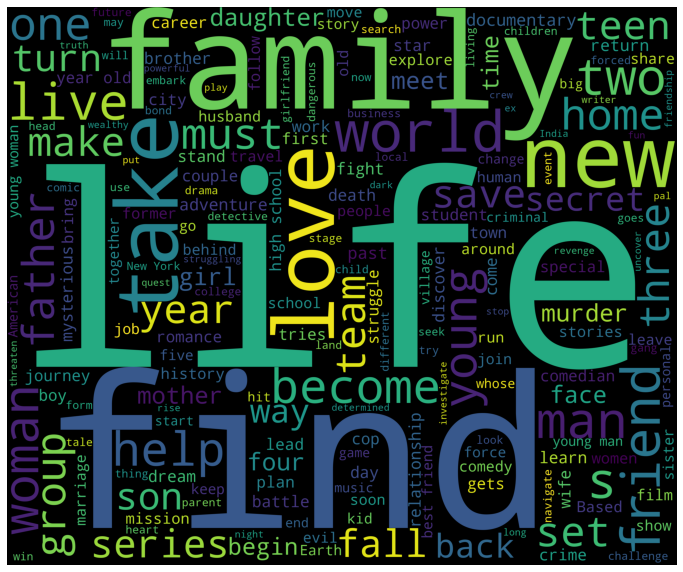

In [48]:
new_df = netflix['description']
words = ' '.join(new_df)
cleaned_word = " ".join([word for word in words.split()
                                                     ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Using cosine similarity

In [22]:
def create_soup(x):
    return x['title']+ ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

netflix['soup'] = netflix.apply(create_soup, axis=1)

In [23]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(netflix['soup'])

# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

# Reset index of our main DataFrame and construct reverse mapping as before
netflix_df=netflix.reset_index()
indices = pd.Series(netflix.index, index=netflix_df['title'])

In [25]:
def get_recommendations(title, cosine_sim = cosine_sim2):
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return netflix_df['title'].iloc[movie_indices]

recommendations = get_recommendations('Jaws', cosine_sim2)
print(recommendations)

42                                    Jaws 2
44                         Jaws: The Revenge
7071      Indiana Jones and the Last Crusade
43                                    Jaws 3
7073    Indiana Jones and the Temple of Doom
579                             Midnight Run
8435                             The Natural
801          Never Back Down 2: The Beatdown
2059                                  Adrift
279     Monster Hunter: Legends of the Guild
Name: title, dtype: object
